
# Analiza meteoroloških podatkov (vir : ARSO)
## Uvoz podatkov

Podatki so že prej bili naloženi s programoma <TT>prenos-identifikatorjev.py</TT> in <TT>podatki-posameznih-postaj.py</TT>

Datoteka <TT>slovar.csv</TT> vsebuje povezavo med imenom postaje in njenim identifikatorjem. 

V <i>/postaje/</i> so datoteke s podatki posameznih postaj po imenih <TT>HXXXX_t_30.html.csv</TT>, kjer XXXX predstavlja identifikacijsko številko postaje.

In [12]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from IPython.display import display, Javascript
import IPython

In [13]:
slovar=[*csv.DictReader(open('slovar.csv'))] #odprem in shranim slovar od prej kot slovar tukaj

In [14]:
def spremeni_v_float(seznam):
    """
    Funkcija, ki sprejme 2 dimenzionalen seznam (n,4) [datum, višina, pretok, temperatura] in vrne številčni 2d array [višina, pretok]

    Vsak "-" v drugem in tretjem stolpcu spremeni v -1, da lahko potem s seznamom upravljamo kot s števili
    """
    for indeks, i in enumerate(seznam):
        for jndeks, j in enumerate(i):
            if j=='-':
                seznam[indeks, jndeks]="-1"
    #print(list(np.asfarray(seznam[1])))
    novseznam = np.array([np.asfarray(seznam[1]), np.asfarray(seznam[2])])
    
                
    #seznam[1::, 1] = np.asfarray(seznam[1::, 1]) ni hotelo delati iz nekega razloga, zato grem na loope
    #seznam[1::, 2] = np.asfarray(seznam[1::, 2])
    #seznam[1::, 3] = np.asfarray(seznam[1::, 3])

    return novseznam 

In [15]:
def dobi_podatke(ID):
    """
    Funkcija, ki iz ID-ja pridobi tabelo za uporabo v spremeni_v_float
    """

    arry = np.loadtxt("postaje/" + ID + ".csv",
                 delimiter=",", dtype=str)

    arry = np.transpose(np.delete(arry, 0, 0))
    return arry

In [16]:
arr = dobi_podatke(slovar[3]["ID"])
arr = spremeni_v_float(arr)
n = len(arr[0])

In [17]:
arr

array([[52.   , 52.   , 52.   , ..., 75.   , 75.   , 74.   ],
       [ 0.648,  0.648,  0.648, ...,  1.55 ,  1.55 ,  1.5  ]])

In [18]:
order = np.argsort(arr[1::,1])
xs = np.array(arr[1::,1])[order][100:120]
ys = np.array(arr[1::,2])[order]
xs


array([], dtype=float64)

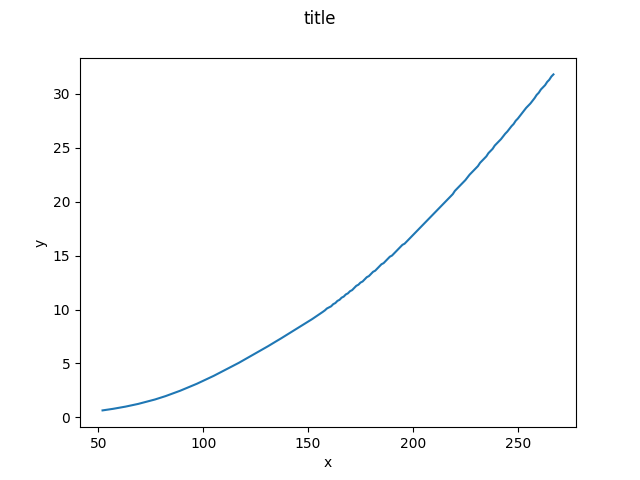

In [19]:
order = np.argsort(arr[0])
xs = np.array(arr[0])[order]
ys = np.array(arr[1])[order]

fig = plt.figure()
ax = plt.subplot()

fig.suptitle('title')
plt.xlabel('x')
plt.ylabel('y')

ax.plot(xs, ys, label='desc' )
plt.show()

In [20]:
fit = np.poly1d(np.polyfit(xs, ys, 2))
print(np.polyfit(xs, ys, 2))
x = np.linspace(-xs[-1], xs[-1], 200)
plt.plot(x, fit(x))

[ 0.00051744 -0.01953158  0.15553301]


In [21]:
np.asfarray(arr[1::, 1]).copy()

array([0.648])

In [22]:
arr[1::, 1]

array([0.648])

In [23]:
n

1439

In [24]:
plt.plot(np.linspace(0,1, n), arr[1])

{'Ime': 'Celje II', 'Reka': 'Savinja', 'ID': 'H6140_t_30.html'}
{'Ime': 'Celje II', 'Reka': 'Voglajna', 'ID': 'H6720_t_30.html'}
'Ime': 'Laško', 'Reka': 'Savinja', 'ID': 'H6200_t_30.html'}

In [25]:
savinja = ['H6140_t_30.html', 'H6720_t_30.html', 'H6200_t_30.html'] #savinja v celju, voglajna v Celju, savinja v laškem

In [26]:
pretoki_savinje = [spremeni_v_float(dobi_podatke(i)) for i in savinja]

In [27]:
%matplotlib inline
#%matplotlib inline

In [28]:
#%matplotlib notebook

In [19]:
#%matplotlib widget

In [20]:
#%matplotlib ipympl

interactive(children=(IntSlider(value=500, description='w', max=1500, min=-500), IntSlider(value=200, descript…

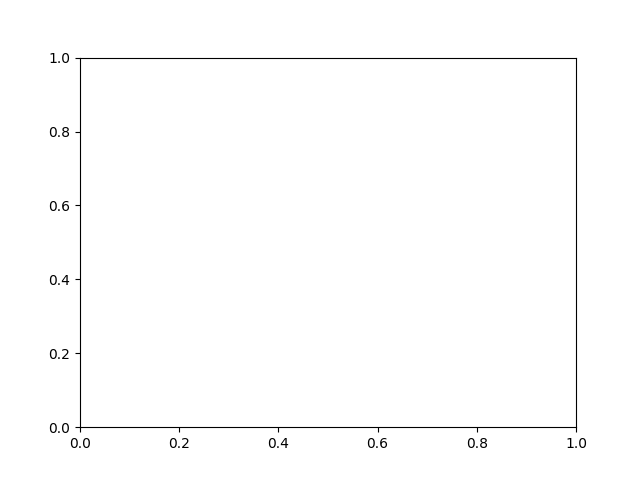

In [37]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1, 200)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#line, = ax.plot(x, pretoki_savinje[0][1][500:500+200])

def update(w = 500, dolz = 200):
    line.set_ydata(pretoki_savinje[0][1][w:w+dolz], pretoki_savinje[2][1][w:w+dolz])
    line.set_xdata(np.linspace(0, 1, dolz))
    fig.canvas.draw_idle()

interact(update);

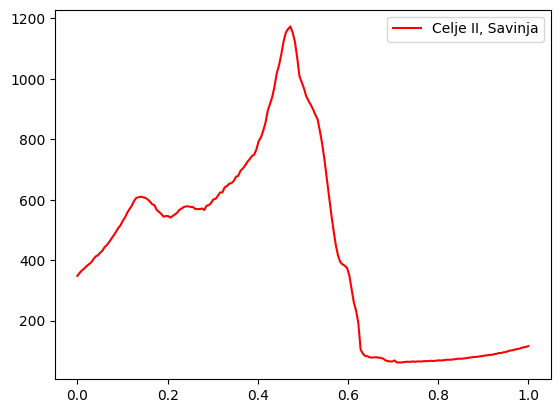

In [21]:
k=500
dolz=200
plt.plot(np.linspace(0,1, dolz), pretoki_savinje[0][1][k:k+dolz], color = "red", label = "Celje II, Savinja")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[1][1][k:k+dolz], color = "green", label = "Celje II, Voglajna")
#plt.plot(np.linspace(0,1, dolz), pretoki_savinje[2][1][k:k+dolz], color = "aqua", label = "Laško, Savinja")
plt.legend()
plt.show()

In [22]:
plt.close()

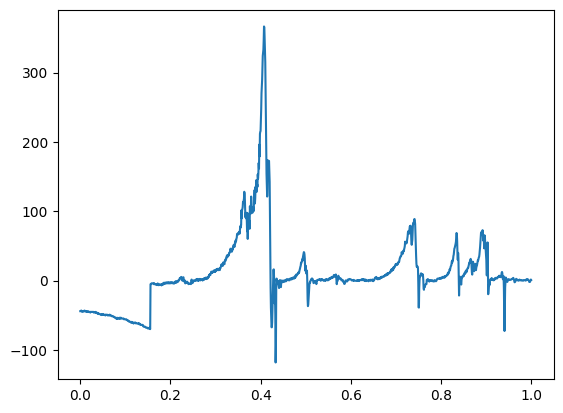

In [23]:
c = pretoki_savinje[2][1]-pretoki_savinje[0][1] - pretoki_savinje[1][1]
plt.plot(np.linspace(0,1, n), c)


In [24]:
def casovna_razlika():
    return 0

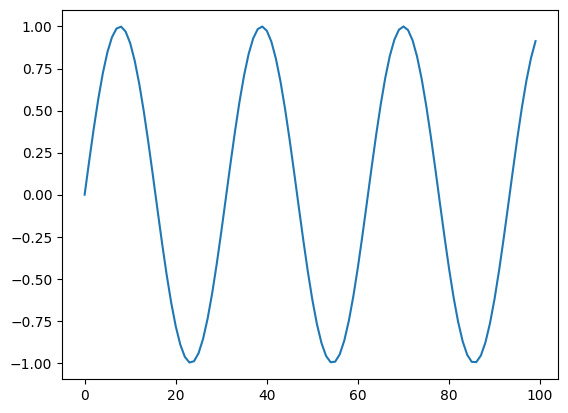

In [25]:
fig = plt.figure()
plt.plot(np.sin(np.linspace(0, 20, 100)));

In [26]:
from ipywidgets import interact

In [42]:
def slika(amplituda=1, fr=10, faza=0, dušenje=0.):
    plt.clf()
    t = np.linspace(0, 1, 200)
    f = amplituda * np.sin(2*np.pi*fr*t - faza) * np.exp(-dušenje*2*np.pi*fr*t)
    plt.plot(t, f)
    #plt.ylim(-5, 5)
    plt.show()

In [43]:
interact(slika);

interactive(children=(IntSlider(value=1, description='amplituda', max=3, min=-1), IntSlider(value=10, descript…

In [29]:
plt.close()

interactive(children=(FloatSlider(value=1.0, description='w', max=3.0, min=-1.0), Output()), _dom_classes=('wi…

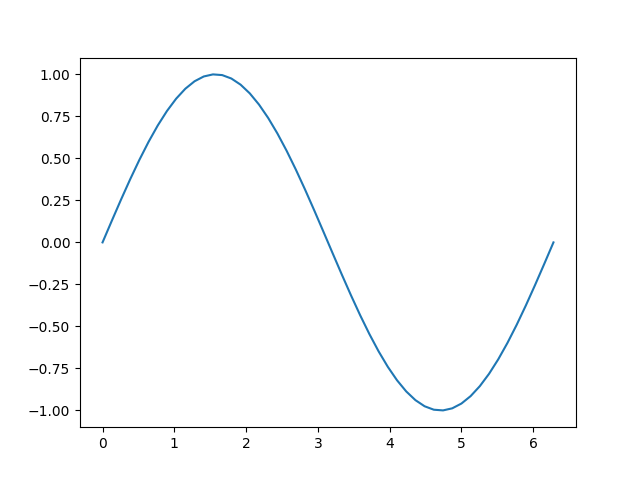

In [1]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2 * np.pi)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, np.sin(x))

def update(w = 1.0):
    line.set_ydata(np.sin(w * x))
    fig.canvas.draw_idle()

interact(update);

In [29]:
plt.close()